In [1]:
import Pkg
Pkg.activate("..")
import WCA1

 Activating environment at `/mnt/data/L2S/myWCA1/Project.toml`


In [2]:
import WAV
x, fs = WAV.wavread("../samples/speech_signal_example.wav")
x = reshape(x, length(x))
X = WCA1.stft(x, 1000, 900; fs=fs, window=WCA1.hanning)

# chirpiness matrix
VV = WCA1.compute_chirpiness(X)
V = reshape(VV, length(VV))

# slope matrix
slope_mat, z = WCA1.slopes(X, -5, 5, 500)
slope = z[Int.(slope_mat[slope_mat .!== nothing])];

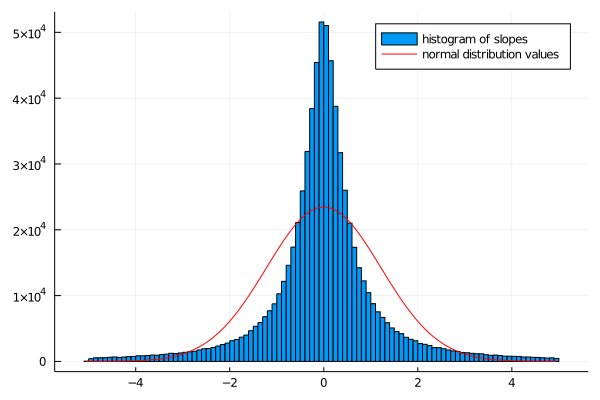

In [25]:
using Distributions, StatsBase, HypothesisTests, LinearAlgebra

histo(data, nbins) = fit(Histogram, data; closed=:right, nbins=nbins)
proba(distribution, a, b) = cdf(distribution, b) - cdf(distribution, a)

# histogram of slopes
h = histo(slope, 100)
nbins = length(h.weights)
bins = h.edges[1]
mid_range(bins) = first(bins)+0.5*step(bins):step(bins):last(bins)-0.5*step(bins)
mid_bins = mid_range(bins)

# normal distribution of slopes
m, std = mean_and_std(slope)
nd = Normal(m, std)
nd_val = pdf.(nd, mid_bins)

# plot
using Plots
plot(h, label="histogram of slopes")
plot!(mid_bins, nd_val * step(mid_bins) * length(slope), color="red", label="normal distribution values")

1.0


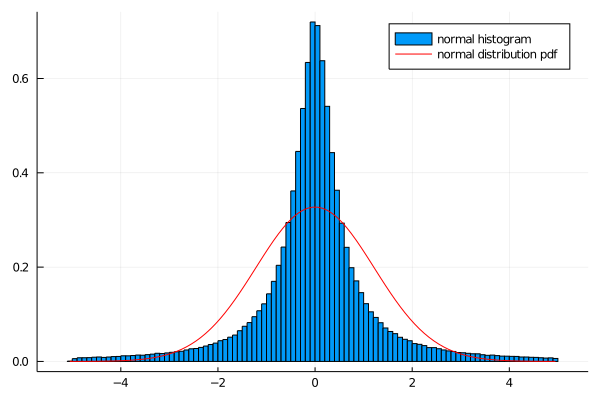

In [7]:
# normalize histogram (mode = probability distribution function)
# in this mode: sum(histogram weights) * bin_size = 1
h1 = normalize(h, mode=:pdf)
println(sum(h1.weights) * step(bins))
plot(h1, label="normal histogram")
plot!(mid_bins, nd_val, color="red", label="normal distribution pdf")

1.0


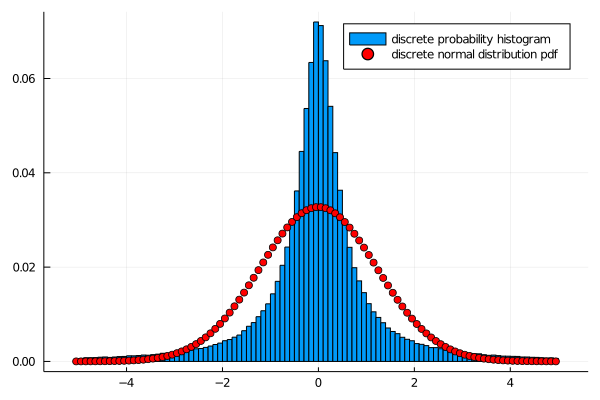

In [9]:
# normalize histogram (mode = discrete probabilities)
# in this mode: sum(histogram weights) = 1
h1p = normalize(h, mode=:probability)
println(sum(h1p.weights))
plot(h1p, label="discrete probability histogram")
plot!(mid_bins, nd_val * step(mid_bins), seriestype = :scatter, color="red", label="discrete normal distribution pdf")

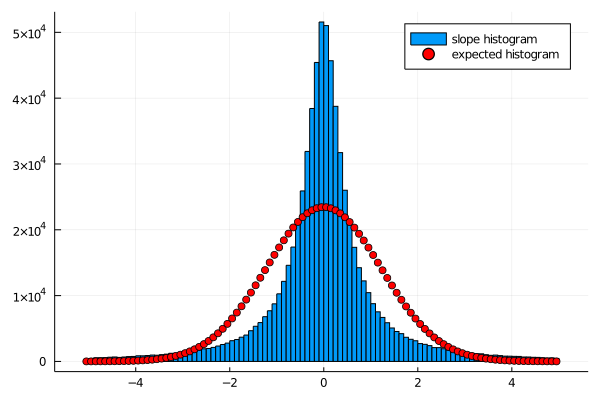

In [10]:
# expected normally distributed expected histogram
expected = [proba(nd, bins[i], bins[i+1]) * length(slope) for i in 1:nbins]
plot(h, label="slope histogram")
scatter!(mid_bins, expected, color="red", label="expected histogram")

χ² = 579293.170786159


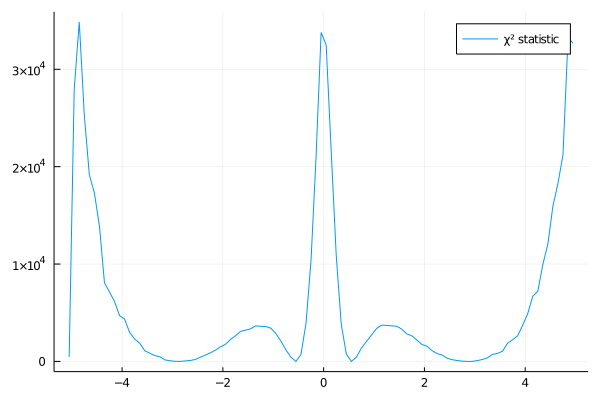

In [11]:
# calculate chi-squared statistic
chi2_stat = (h.weights .- expected).^2 ./ expected
chi2_val = sum(chi2_stat)
println("χ² = ", chi2_val)
plot(mid_bins, chi2_stat, label="χ² statistic")

In [13]:
chi2 = Chisq(nbins - 3)
println("P(χ²) = ", cdf(chi2, chi2_val))
println("P(α=5%) = ", cdf(chi2, 0.05))
pval = 1 - cdf(chi2, chi2_val)
println("p-value = ", pval)
println("H0 Hypothesis is $(pval > 0.05 ? "accepted" : "rejected") for α=5%")

P(χ²) = 1.0
P(α=5%) = 5.061921363649885e-142
p-value = 0.0
H0 Hypothesis is rejected for α=5%


## `HypothesisTests.jl`

In [20]:
# apply χ² test from HypothesisTests.jl
# takes histogram and vector of probabilities such that sum(proba) = 1
println(sum(nd_val) * step(bins))
ChisqTest(h.weights, nd_val*step(bins))

0.9999656828328913

LoadError: ArgumentError: Probabilities must sum to one

In [21]:
ChisqTest(h.weights, nd_val / sum(nd_val))

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [6.11287e-6, 8.56044e-6, 1.19075e-5, 1.64521e-5, 2.25784e-5, 3.07781e-5, 4.16738e-5, 5.6048e-5, 7.4874e-5, 9.93518e-5  …  0.000130114, 9.87045e-5, 7.43744e-5, 5.56653e-5, 4.13828e-5, 3.05583e-5, 2.24137e-5, 1.63294e-5, 1.18169e-5, 8.49395e-6]
    point estimate:          [6.83958e-5, 0.000587646, 0.000774687, 0.000780271, 0.000801208, 0.000894729, 0.000943583, 0.000852854, 0.000939396, 0.00102454  …  0.00107619, 0.00106083, 0.000940792, 0.000936604, 0.000877979, 0.000857042, 0.000780271, 0.000713271, 0.00075375, 0.000632312]
    95% confidence interval: [(0.0, 0.0008), (0.0, 0.0014), (0.0, 0.0015), (0.0, 0.0015), (0.0, 0.0016), (0.0001, 0.0017), (0.0002, 0.0017), (0.0001, 0.0016), (0.0002, 0.0017), (0.0003, 0.0018)  …  (0.0003, 0.0018), (0.0003, 0.0018), (0.0002, 0.0017), (0.0002, 0.0017), (0.0001, 0.0016), (0.0001, 0.0016), (0.0, 0

In [23]:
ChisqTest(round.(Int, expected), nd_val / sum(nd_val))

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [6.11287e-6, 8.56044e-6, 1.19075e-5, 1.64521e-5, 2.25784e-5, 3.07781e-5, 4.16738e-5, 5.6048e-5, 7.4874e-5, 9.93518e-5  …  0.000130114, 9.87045e-5, 7.43744e-5, 5.56653e-5, 4.13828e-5, 3.05583e-5, 2.24137e-5, 1.63294e-5, 1.18169e-5, 8.49395e-6]
    point estimate:          [5.58352e-6, 8.37528e-6, 1.25629e-5, 1.67506e-5, 2.23341e-5, 3.07094e-5, 4.18764e-5, 5.58352e-5, 7.53775e-5, 9.91075e-5  …  0.000129817, 9.91075e-5, 7.39816e-5, 5.58352e-5, 4.18764e-5, 3.07094e-5, 2.23341e-5, 1.67506e-5, 1.25629e-5, 8.37528e-6]
    95% confidence interval: [(0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0007), (0.0, 0.0007), (0.0, 0.0007), (0.0, 0.0007)  …  (0.0, 0.0007), (0.0, 0.0007), (0.0, 0.0007), (0.0, 0.0007), (0.0, 0.0007), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0006), (0.0, 0.0

In [26]:
using Random
Random.seed!(123)
y = rand(nd, length(slope))

hy = histo(y, 100)
ndy = pdf.(nd, mid_range(hy.edges[1]))
ChisqTest(hy.weights, ndy / sum(ndy))

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [1.1623e-6, 2.47131e-6, 5.11486e-6, 1.03048e-5, 2.02088e-5, 3.85779e-5, 7.16859e-5, 0.000129666, 0.000228306, 0.000391295  …  3.82933e-5, 2.00534e-5, 1.02223e-5, 5.07234e-6, 2.44999e-6, 1.15191e-6, 5.27192e-7, 2.34864e-7, 1.0185e-7, 4.29937e-8]
    point estimate:          [1.39583e-6, 6.97917e-6, 8.375e-6, 1.11667e-5, 2.09375e-5, 3.90833e-5, 9.35208e-5, 0.000113062, 0.000195417, 0.000388042  …  3.35e-5, 1.81458e-5, 8.375e-6, 4.1875e-6, 5.58333e-6, 2.79167e-6, 1.39583e-6, 1.39583e-6, 0.0, 1.39583e-6]
    95% confidence interval: [(0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0009), (0.0, 0.0009), (0.0, 0.001), (0.0, 0.0012)  …  (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008), (0.0, 0.0008)]

Test 

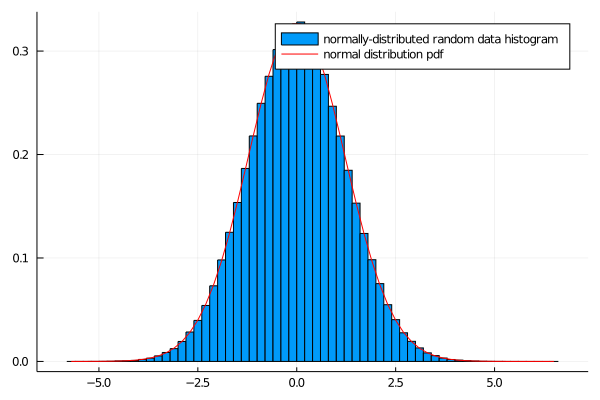

In [27]:
plot(normalize(hy, mode=:pdf), label="normally-distributed random data histogram")
plot!(mid_range(hy.edges[1]), ndy, color="red", label="normal distribution pdf")

## `RCall.jl`

In [39]:
using RCall
@rlibrary("nortest")

In [40]:
@rput slope
@rput y

716418-element Array{Float64,1}:
  1.4490118649476873
  2.494261770218483
  1.3909969963874491
  0.5585669121322712
 -0.48446906873453566
 -0.8110317131518711
  1.1940079647567108
 -0.09313502767632571
  0.3324380293866248
 -0.23781102130823567
 -0.41464084434610093
 -1.0293205707103714
 -1.084217456744773
  ⋮
 -0.7358874230578514
  1.0188385472748425
  0.6316780287949477
  2.950804579451612
  1.8810680753559856
 -0.7813296131962294
 -1.4031555417860837
 -0.28903689116587117
 -0.26623943030409875
 -1.4720157007917007
  0.9126193143061795
 -1.2564189506873118

In [41]:
R"pearson.test($y)"

RObject{VecSxp}

	Pearson chi-square normality test

data:  `#JL`$y
P = 426.04, p-value = 0.6373



In [42]:
R"pearson.test($slope)"

RObject{VecSxp}

	Pearson chi-square normality test

data:  `#JL`$slope
P = 1801014, p-value < 2.2e-16

